In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

from tqdm.auto import tqdm

from scipy import stats

sns.set(rc={'figure.figsize':(11.7,8.27)})

import pandahouse as ph

In [2]:
connection = {
    'host': 'https://clickhouse.XXXXXXXXXXXXXXXXXXXXX',
    'password': 'XXXXXXXXXXXX',
    'user': 'XXXXXXXXXX',
    'database': 'XXXXXXXXXXX'   
}

In [3]:
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20230120.feed_actions 
WHERE toDate(time) between '2023-01-01' and '2023-01-07'
    and exp_group in (2,1)
GROUP BY exp_group, user_id
"""

In [4]:
df = ph.read_clickhouse(q, connection=connection)

In [5]:
df  # group 2 - experimental; group 1 - control

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750
...,...,...,...,...,...
20026,1,132567,45,296,0.152027
20027,1,30872,11,59,0.186441
20028,2,25383,42,127,0.330709
20029,2,139020,24,114,0.210526


**_I would like to have an idea what we are dealing with, so let's check the groups for normal distribution and homogeneity of variance_** 

In [6]:
# Let's check our groups for the homogeneity of the variance, using the Levene test

group_2 = df[df.exp_group == 2].ctr
group_1 = df[df.exp_group == 1].ctr

In [7]:
stats.levene(group_2, group_1)

LeveneResult(statistic=2423.111217314751, pvalue=0.0)

#### Conclusion: p<0.05, we reject the hypothesis H(0) about the same variance in the groups, the variance is inhomogeneous
>

In [8]:
# Let's check our groups for normal distribution, use the Shapiro-Wilk test
# The null hypothesis H(0) in the Shapiro-Wilk case is the normal distribution of the metric

stats.shapiro(group_2)

/nfs/env/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.8864326477050781, pvalue=0.0)

In [9]:
stats.shapiro(group_1)

ShapiroResult(statistic=0.9498439431190491, pvalue=0.0)

#### Conclusion: p<0.05, we reject the hypothesis H(0), the distribution is not normal
>

###  Student's t-test

In [10]:
stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 1].ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.7094392041270486, pvalue=0.4780623130874935)

#### Conclusion: p>0.05, we cannot reject the H(0) hypothesis about the absence of a statistically significant difference in the 'ctr' metric

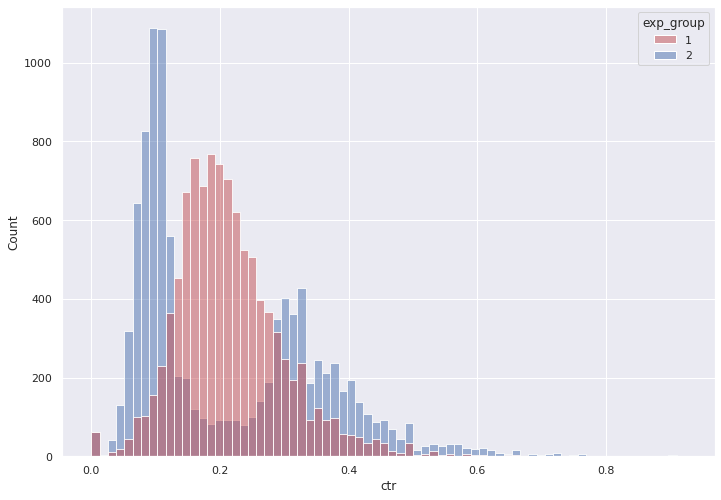

In [11]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [12]:
df[df.exp_group == 2].ctr.mean(), df[df.exp_group == 1].ctr.mean()

# interesting, judging by the average values of 'ctr' it can be seen that they are almost the same,
# our t-test cannot tell the difference

(0.21441927347479375, 0.21560459841296287)

>
###  Mann-Whitney test

In [13]:
stats.mannwhitneyu(df[df.exp_group == 2].ctr, 
                   df[df.exp_group == 1].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=43704947.5, pvalue=6.0376484617779035e-56)

#### Conclusion: the Mann-Whitney test shows the presence of a statistically significant difference in the 'ctr' metric
>

###  Student's t-test on smoothed CTR (α=5)

_Laplace smoothing: smoothed_CTR = (clicks + α ∗ globalCTR) \ (views + α)_

In [14]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [15]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20230120.feed_actions 
WHERE toDate(time) between '2023-01-01' and '2023-01-07'
    and exp_group in (2,1)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

In [16]:
# global CTR

global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()

/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ctr'>

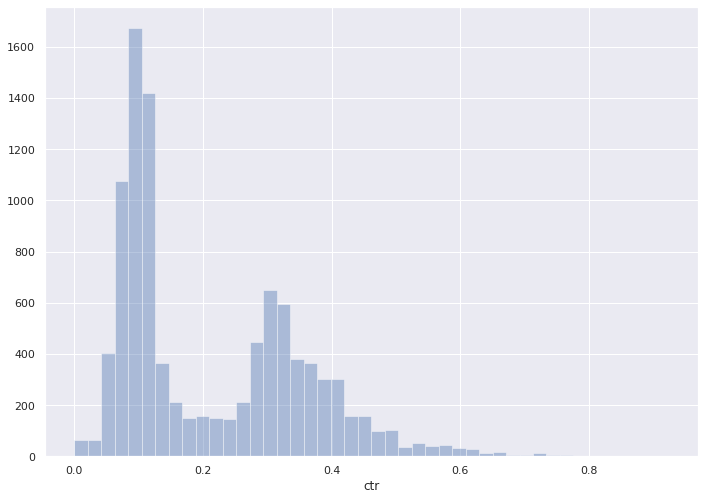

In [17]:
# histogram of regular CTR

group2 = df[df.exp_group == 2].copy()
sns.distplot(group2.ctr, kde = False)

<AxesSubplot:xlabel='smothed_ctr'>

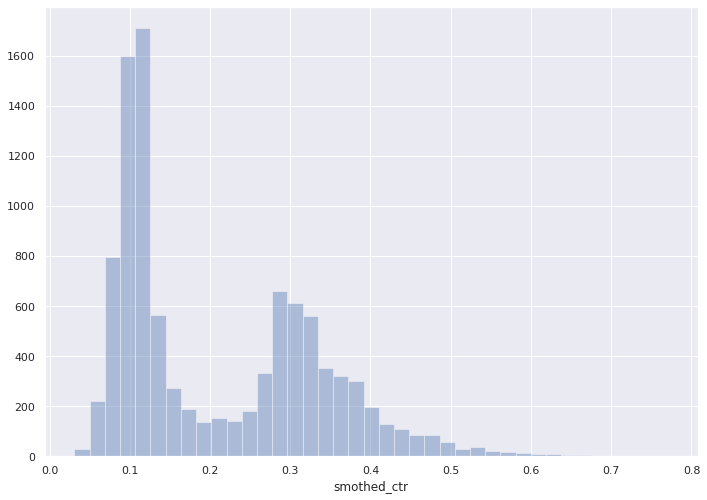

In [18]:
# histogram of smoothed CTR

group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.distplot(group2.smothed_ctr, 
             kde = False)

In [19]:
group1 = df[df.exp_group == 1].copy()

group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

In [20]:
# Student's t-test

stats.ttest_ind(group2['smothed_ctr'],
                group1['smothed_ctr'],
                equal_var=False)

Ttest_indResult(statistic=-2.2841320431616983, pvalue=0.0223769815558559)

#### Conclusion: Student's t-test on the smoothed CTR (α=5) shows a statistically significant difference in the 'ctr' metric
>

###  Poisson bootstrap

<AxesSubplot:ylabel='Count'>

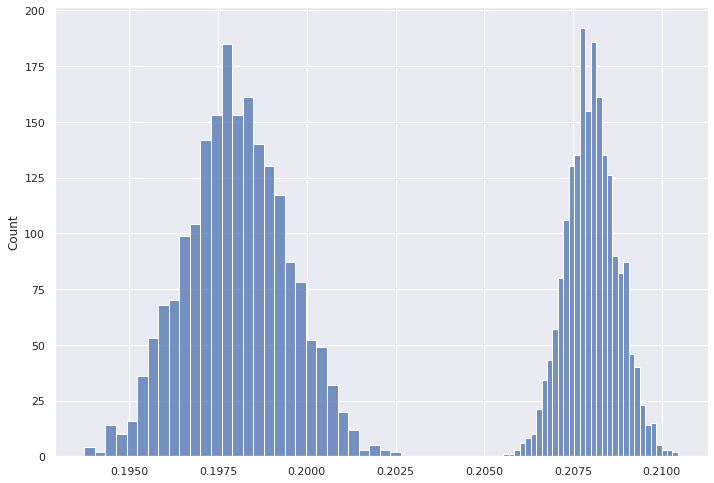

In [21]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20230120.feed_actions 
WHERE toDate(time) between '2023-01-01' and '2023-01-07'
    and exp_group in (2,1)
GROUP BY exp_group, user_id
"""


df = ph.read_clickhouse(q, connection=connection)

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

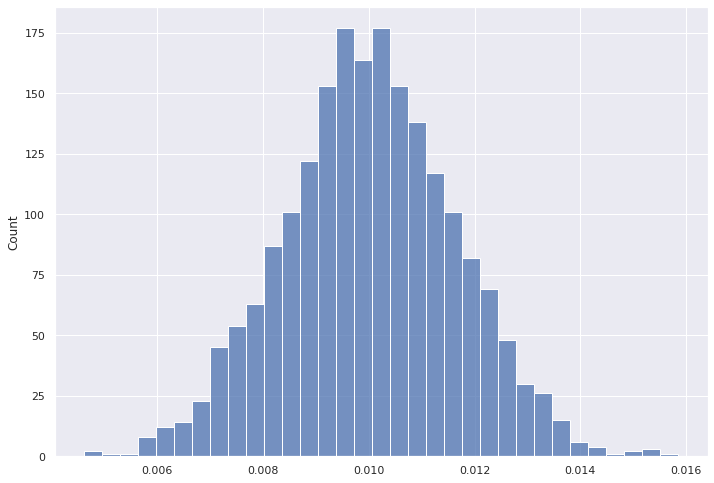

In [22]:
# Distribution of the difference between "global CTR"

sns.histplot(ctr1 - ctr2)

####   Conclusion: the histogram of the difference is located to the right of the "0" mark, this indicates that the difference is present and it is positive. The CTR of experimental group 2 is less than the CTR of control group 1.
>

###   Student's t-test and Mann-Whitney test over bucket transform

In [23]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20230120.feed_actions 
    WHERE toDate(time) between '2023-01-01' and '2023-01-07'
        and exp_group in (2,1)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = ph.read_clickhouse(q, connection=connection)

In [24]:
# t-test

stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

#### Conclusion: Student's t-test over bucket transform shows a statistically significant difference in the 'ctr' metric
>

In [25]:
# Mann-Whitney test 

stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

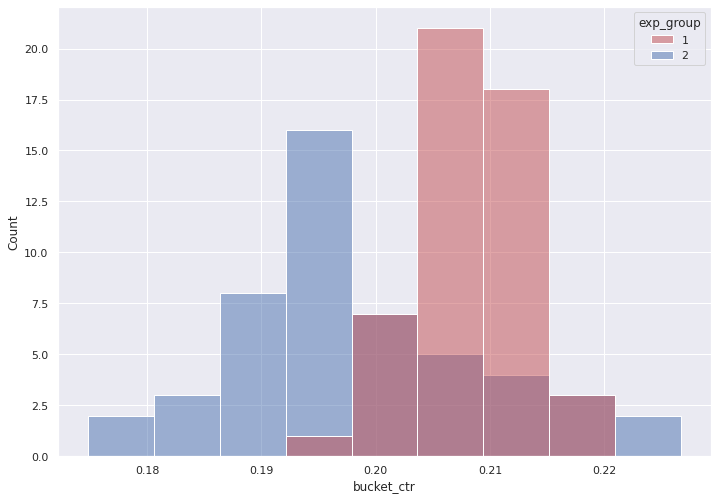

In [26]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = df, 
              x='bucket_ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

#### Conclusion: the Mann-Whitney test over the bucket transform shows the presence of a statistically significant difference in the 'ctr' metric
>

#### General conclusion:    
as a result of applying the battery of tests, the following information was obtained regarding the presence (absence) of statistically significant differences in the 'CTR' metric between experimental group 2 and control group 1:

    1) Student's t-test - absent;
    2) Mann-Whitney test - yes;
    3) Student's t-test on the smoothed CTR (α=5) - yes;
    4) Poisson bootstrap - yes;
    5) Student's t-test over bucket transformation - yes;
    6) Mann-Whitney test over bucket transformation - yes;
    
On the 'CTR' distribution graph in groups 1 and 2, we can observe the presence of outliers, in addition, the 'CTR' distribution graph of group 2 can hardly be called symmetrical and unimodal. In addition, it was found that in the groups under consideration, the variance is inhomogeneous and the distribution is not normal, thus the question of confidence in the Student's t-test (at least in the classical interpretation) arises. More confidence is caused by the Mann-Whitney nonparametric. We consider the Poisson bootstrap to be the most informative and credible, which not only shows the presence of statistically significant differences in the 'CTR' metric between groups 1 and 2, but also from which it follows that the CTR of the experimental group 2 is less than the CTR of the control group 1. And this speaks rather all that the experimental technique **not only did not lead to an increase in CTR, but even vice versa.**

In our opinion, **it is not worth rolling out a new algorithm to all new users.**

Yes, as a result of the application of the new algorithm, the CTR indicator has become worse, but does this mean that the experiment is useless? We see that our new algorithm "pulled" our initial peak not only to the left, but also to the right, that is, people appeared whose CTR became significantly higher.\
Then maybe it is necessary to compare not the average CTR, but some quantile of the distribution of CTRs?\
The question remains open for research: due to what our distribution "went" to the right, increasing the number of users who bring money?

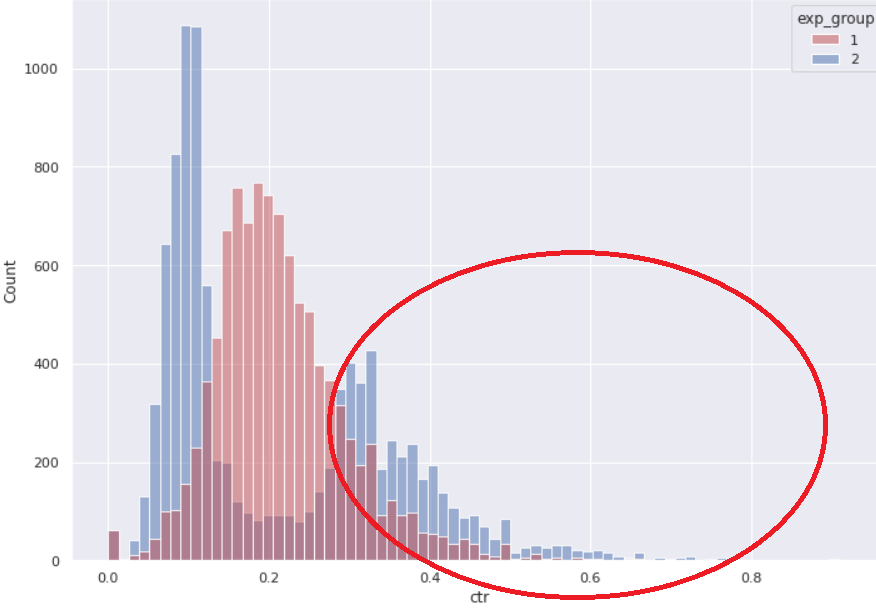